# Experiments with parallel processes

## Preliminaries

In [2]:
%load_ext autoreload
%autoreload 2

from epsilon_transformers.persistence import S3Persister, HackyPersister
from epsilon_transformers.training.configs.model_configs import RawModelConfig
from epsilon_transformers.process.processes import RRXOR, EvenProcess, GoldenMean, Mess3, RIP, TransitionMatrixProcess, ZeroOneR
from epsilon_transformers.analysis.activation_analysis import get_beliefs_for_transformer_inputs
from epsilon_transformers.comp_mech.reversal import reverse_process, get_recurrent_component_process_from_mstree, get_prob_forward_given_past, joint_prob_from_conditional
from epsilon_transformers.visualization.graph import transition_matrix_to_graph, visualize_graph
from typing import Dict, Tuple
from tqdm.auto import tqdm

import numpy as np
import plotly.express as px
import pathlib
from typing import List, Dict, Optional, Tuple, Iterable
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA


from transformer_lens import HookedTransformer, HookedTransformerConfig
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import IterableDataset, DataLoader


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Functions 

In [3]:
# Functions to create processes
def combine_process(process1, process2):
    T1 = process1.transition_matrix
    T2 = process2.transition_matrix
    T_combined = np.einsum('ijk,lmn->iljmkn', T1, T2)
    M1, N1, _ = T1.shape
    M2, N2, _ = T2.shape
    T_combined = T_combined.reshape(M1*M2, N1*N2, N1*N2)
    new_proc = TransitionMatrixProcess(T_combined)
    return new_proc

def calculate_myopic_entropy_rate(process: TransitionMatrixProcess, depth: int = 9) -> float:
    # Derive the mixed state tree
    msp = process.derive_mixed_state_tree(depth=depth)
    # Calculate the myopic entropy rate
    return msp.myopic_entropy

def visualize_process(process, depth):
    msp = process.derive_mixed_state_tree(depth=depth)
    msp_transition, _ = msp.build_msp_transition_matrix()
    msp_process = TransitionMatrixProcess(msp_transition)
    msp_process_graph = transition_matrix_to_graph(msp_process.transition_matrix)
    visualize_graph(msp_process_graph, draw_mixed_state=True, draw_edge_labels=True, draw_color=True)

def build_process_msp(process, depth, name, verbose=False):
    msp = process.derive_mixed_state_tree(depth=depth)
    msp_transition, _ = msp.build_msp_transition_matrix()
    msp_process = TransitionMatrixProcess(msp_transition)
    msp_process_graph = transition_matrix_to_graph(msp_process.transition_matrix)
    tree_paths, tree_beliefs = msp.paths_and_belief_states
    myopic_entropy_rate = msp.myopic_entropy
    
    if verbose:
        visualize_graph(msp_process_graph, draw_mixed_state=True, draw_edge_labels=True, draw_color=True)
        print(f"{name} myopic_entropy_rate: {myopic_entropy_rate}")

        print(f"\nFirst few paths and beliefs for {name}:")
        for path, belief in zip(tree_paths[:5], tree_beliefs[:5]):
            print(f"Path: {''.join([str(x) for x in path])}, Belief: {belief}")

        msp_beliefs = [tuple(round(b, 5) for b in belief) for belief in tree_beliefs]
        print(f"Number of Unique beliefs: {len(set(msp_beliefs))} out of {len(msp_beliefs)}")

        msp_belief_index = {b: i for i, b in enumerate(set(msp_beliefs))}

        print(f"\nFirst few belief indices for {name}:")
        for i in range(min(5, len(msp_belief_index))):
            ith_belief = list(msp_belief_index.keys())[i]
            print(f"{ith_belief} is indexed as {msp_belief_index[ith_belief]}")
    else:
        msp_beliefs = [tuple(round(b, 5) for b in belief) for belief in tree_beliefs]
        msp_belief_index = {b: i for i, b in enumerate(set(msp_beliefs))}

    return msp, tree_paths, tree_beliefs, msp_belief_index, myopic_entropy_rate


In [4]:
# Functions for training the transformer

def SetHookedTrans(train_config, device='cpu', verbose=False):
    # instantiate pytorch transformer model using our config
    config = HookedTransformerConfig(
        d_model=train_config['d_model'],
        d_head=train_config['d_head'],
        n_layers=train_config['n_layers'],
        n_ctx=train_config['n_ctx'],
        n_heads=train_config['n_heads'],
        d_mlp=train_config['d_mlp'],
        d_vocab=train_config['d_vocab'],
        seed=train_config['seed'],
        device=device,
        act_fn=train_config['act_fn'],
        attn_only=train_config['attn_only'],
        normalization_type=train_config['normalization_type'],
    )
    print(device)
    model = HookedTransformer(config)

    if verbose:
        print(model)
        for name, p in model.named_parameters():
            if p.requires_grad:
                print(name)
                print(f"     {p.numel()}, {list(p.shape)}")
        total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Total model parameters: {total_parameters}")

    optimizer_dict = {
        'sgd': torch.optim.SGD,
        'adam': torch.optim.Adam,
        'adamw': torch.optim.AdamW,
    }
    optim = optimizer_dict[train_config['optimizer'].lower()]
    optimizer = optim(model.parameters(), lr=train_config['learning_rate'], weight_decay=train_config['weight_decay'])
    criterion = nn.CrossEntropyLoss(reduction="none")

    return model, optimizer, criterion


class CustomProcessDataset(IterableDataset):

    def __init__(self, process, sequence_length, num_samples, fixed=False):
        super().__init__()
        self.process = process
        self.sequence_length = sequence_length
        self.num_samples = num_samples
        self.fixed = fixed
        if self.fixed:
          self.samples = list(self._get_samples())
        else:
          self.samples = None

    def _get_samples(self):
      return self.process.yield_emissions(
            sequence_len=self.num_samples * (self.sequence_length + 1)
        )

    def __len__(self):
        return self.num_samples

    def __iter__(self) -> Iterable[Tuple[List[int]]]:
        samples = self._get_samples() if self.samples is None else iter(self.samples)
        for _ in range(self.num_samples):
            process_history = [
                next(samples) for _ in range(self.sequence_length + 1)
            ]
            yield (process_history[:-1], process_history[1:])
    
    def __getitem__(self, idx):
        if idx >= self.num_samples:
            raise IndexError("Index out of range")
        if self.fixed:
            start = idx * (self.sequence_length + 1)
            end = start + self.sequence_length + 1
            process_history = self.samples[start:end]
        else:
            process_history = [
                next(self._get_samples()) for _ in range(self.sequence_length + 1)
            ]
        return (process_history[:-1], process_history[1:])

def process_dataset_collate_fn(batch: List[Tuple[List[int]]]):
    data = [x[0] for x in batch]
    labels = [x[1] for x in batch]
    return torch.tensor(data, dtype=torch.long), torch.tensor(labels, dtype=torch.long)


def compute_losses(loss: torch.Tensor, minimum_cross_entropy: torch.Tensor):
    per_position_loss = loss.mean(dim=0)  # *(n_ctx,)
    relative_loss = per_position_loss[:len(minimum_cross_entropy)] / minimum_cross_entropy#[:len(per_position_loss)]
    mean_loss = per_position_loss.mean()
    return mean_loss, relative_loss


def train_epoch(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    train_dataloader: torch.utils.data.DataLoader,
    valid_dataloader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    minimum_cross_entropy: torch.Tensor,
    device: str,
):
    model.train()
    for X, Y_true in train_dataloader:
        X, Y_true = X.to(device), Y_true.to(device)
        optimizer.zero_grad()
        Y = model(X)  # Forward pass
        loss = criterion(Y.view(-1, model.cfg.d_vocab), Y_true.view(-1))
        loss = loss.view(X.shape[0], X.shape[1])  # *(batch_size, n_ctx)
        mean_loss, relative_loss = compute_losses(loss, minimum_cross_entropy)
        mean_loss.backward()
        optimizer.step()
        log_data = {
            "loss": mean_loss.item(),
            "relative_loss": relative_loss.mean().item(),
        }
        for i, rel_loss in enumerate(relative_loss):
            log_data[f"relative_loss_{i}"] = rel_loss.item()

    # validation
    model.eval()
    with torch.no_grad():
      for X, Y_true in valid_dataloader:
          X, Y_true = X.to(device), Y_true.to(device)
          Y = model(X)
          loss = criterion(Y.view(-1, model.cfg.d_vocab), Y_true.view(-1))
          loss = loss.view(X.shape[0], X.shape[1])  # *(batch_size, n_ctx)
          mean_loss, relative_loss = compute_losses(loss, minimum_cross_entropy)
          log_data["val_loss"] = mean_loss.item()
          log_data["val_relative_loss"] = relative_loss.mean().item()
          for i, rel_loss in enumerate(relative_loss):
              log_data[f"val_relative_loss_{i}"] = rel_loss.item()

    return log_data


def train_model(process, train_config, model, optimizer, criterion, device='cpu', verbose=False):
# n_ctx,n_layers=2, n_heads=2, d_model=64
    minimum_cross_entropy = calculate_myopic_entropy_rate(process, depth=train_config['n_ctx']+1)
    minimum_loss = torch.tensor(minimum_cross_entropy, dtype=torch.float32).to(device)

    train_dataset = CustomProcessDataset(process, sequence_length=train_config['n_ctx'], num_samples=train_config['num_train_samples'],
                                         fixed=train_config['fixed_train_dataset'])
    valid_dataset = CustomProcessDataset(process, sequence_length=train_config['n_ctx'], num_samples=train_config['num_valid_samples'],
                                         fixed=train_config['fixed_valid_dataset'])
    train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], collate_fn=process_dataset_collate_fn)
    valid_dataloader = DataLoader(valid_dataset, batch_size=train_config['batch_size'], collate_fn=process_dataset_collate_fn)

    if verbose:
        print("\n".join(f"{k}: {v}" for k, v in train_config.items()))
        print(f"Using device: {device}")

    for epoch in tqdm(range(1, train_config['num_epochs'] + 1)):
        log_data = train_epoch(model=model,
                               optimizer=optimizer,
                               train_dataloader=train_dataloader,
                               valid_dataloader=valid_dataloader,
                               criterion=criterion,
                               device=device,
                               minimum_cross_entropy=minimum_loss[1:])
        print(f"epoch {epoch:>3d}, loss: {log_data['loss']:.06f}, relative loss: {log_data['relative_loss']:.06f}, "
              f"val loss: {log_data['val_loss']:.06f}, val relative loss: {log_data['val_relative_loss']:.06f}")

## Define the processes

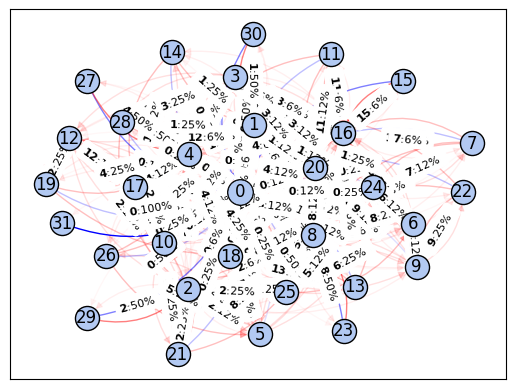

In [5]:
# Define the processes
#PROC = ['Even', 'Golden', 'Golden']
#PROC = ['Even', 'Even', 'Even', 'Even', 'Even', 'Even', 'Even', 'Even']
#PROC = ['Even', 'Even']
PROC = ['Even', 'Even', 'Even', 'Golden','Golden']
PROC = ['Golden', 'Golden', 'Golden', 'Golden','Golden']
N = len(PROC)


# Create basic processes
T_even = np.array([
    [[0.0, 0.5],
     [1.0, 0.0]],

    [[0.5, 0.0],
     [0.0, 0.0]]
])

T_golden = np.array([
    [[0.5, 0.0],
     [1.0, 0.0]],
     
    [[0.0, 0.5],
     [0.0, 0.0]]
])

even_process = TransitionMatrixProcess(T_even)
golden_process = TransitionMatrixProcess(T_golden)

# Construct the joint process
if PROC[0] == 'Even':
    final_process = even_process
elif PROC[0] == 'Golden':
    final_process = TransitionMatrixProcess(T_golden)
else:
    final_process = None

if N > 1:
    for k in range(1,len(PROC)):
        if PROC[k] == 'Golden':
            final_process = combine_process(final_process, golden_process)
        elif PROC[k] == 'Even':
            final_process = combine_process(final_process, even_process)
        else:
            print('Unknown process')
            break

verbose = True
if verbose:
    graph = transition_matrix_to_graph(final_process.transition_matrix) # visualize final frocess
    visualize_graph(graph, draw_mixed_state=True, draw_edge_labels=True, draw_color=True)

In [6]:
# Estimate the belief structure
depth = 4

# build the MSPs
device = 'cuda' if torch.cuda.is_available() else 'cpu'

final_msp, final_tree_paths, final_tree_beliefs, final_msp_belief_index, final_myopic_entropy_rate = build_process_msp(final_process, depth, "Final")
minimum_cross_entropy = final_myopic_entropy_rate 

even_msp, even_tree_paths, even_tree_beliefs, even_msp_belief_index, even_myopic_entropy_rate = build_process_msp(even_process, depth, "Even")
golden_msp, golden_tree_paths, golden_tree_beliefs, golden_msp_belief_index, golden_myopic_entropy_rate = build_process_msp(golden_process, depth, "Golden")

# now lets set up all the inputs as they arrive into the transformer
transformer_inputs = [x for x in final_tree_paths if len(x) == depth-1]
transformer_inputs = torch.tensor(transformer_inputs, dtype=torch.int).to(device)

#proc_transformer_inputs = (transformer_inputs/2).floor()
#even_transformer_inputs = (transformer_inputs + 0) % 2
subproc_inputs = []
for k in range(N):
    inputs = ( (transformer_inputs / (2**(N-k-1)) ) %2).floor()
    subproc_inputs.append(inputs)

transformer_input_beliefs, transformer_input_belief_indices = get_beliefs_for_transformer_inputs(transformer_inputs,
                                                                                                 final_msp_belief_index,
                                                                                                 final_tree_paths,
                                                                                                 final_tree_beliefs)

subprocess_input_beliefs, subprocess_input_belief_indices = [],[]
if N>1:
    for k in range(N):
        name = PROC[k]
        if name == 'Even':
            input_beliefs, input_belief_indices = get_beliefs_for_transformer_inputs(subproc_inputs[k],
                                                                                       even_msp_belief_index,
                                                                                       even_tree_paths,
                                                                                       even_tree_beliefs)
        elif name == 'Golden':
            input_beliefs, input_belief_indices = get_beliefs_for_transformer_inputs(subproc_inputs[k],
                                                                                       golden_msp_belief_index,
                                                                                       golden_tree_paths,
                                                                                       golden_tree_beliefs)
        else:
            print('Unknown process')
            break
        subprocess_input_beliefs.append(input_beliefs)
        subprocess_input_belief_indices.append(input_belief_indices)

## Training the model

In [7]:
n_layers = 4
n_heads = 2
d_model = 128#16
n_ctx = depth-1

n_epochs = 40

device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_config = {
    'n_ctx': n_ctx,
    'd_model': d_model,
    'n_layers': n_layers,
    'n_heads': n_heads,
    'd_head': int(d_model/n_heads),
    'd_mlp': d_model*4,
    'act_fn': 'relu',
    'seed': 42,
    'd_vocab': 2**N,
    'attn_only': False,
    'optimizer': 'adamw', # or sgd or adam
    'batch_size': 500,
    'num_epochs': n_epochs,
    'weight_decay': 0.0,
    'attention_dir': 'causal',
    'learning_rate': 3e-5,
    'normalization_type': 'LN',
    'fixed_train_dataset': False,
    'num_train_samples': 10000,
    'fixed_valid_dataset': True,
    'num_valid_samples': 2000,
}

model, optimizer, criterion = SetHookedTrans(train_config, device=device)


cpu


In [55]:
train_model(final_process, train_config, model, optimizer, criterion, device=device)

  0%|          | 0/40 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [8]:
# Functions to estimate performance
 
def regression_activation_to_beliefs(activations, transformer_input_beliefs):
    # we now have activations [batch, n_ctx, d_model]
    # and we have transformer_input_beliefs [batch, n_ctx, belief_dim]
    # and we have transformer_input_belief_indices [batch, n_ctx]
    # in the end we want to do linear regression between the activations and the transformer_input_beliefs

    # make sure the first two dimensions are the same
    assert activations.shape[0] == transformer_input_beliefs.shape[0]
    assert activations.shape[1] == transformer_input_beliefs.shape[1]

    # flatten the activations
    batch_size, n_ctx, d_model = activations.shape
    belief_dim = transformer_input_beliefs.shape[-1]
    activations_flattened = activations.view(-1, d_model).cpu().numpy() # [batch * n_ctx, d_model]
    transformer_input_beliefs_flattened = transformer_input_beliefs.view(-1, belief_dim).cpu().numpy() # [batch * n_ctx, belief_dim]

    # run the regression and calculate R2
    regression = LinearRegression()
    regression.fit(activations_flattened, transformer_input_beliefs_flattened)
    error = regression.score(activations_flattened, transformer_input_beliefs_flattened)
    
    # get the belief predictions
    belief_predictions = regression.predict(activations_flattened) # [batch * n_ctx, belief_dim]
    belief_predictions = belief_predictions.reshape(batch_size, n_ctx, belief_dim)
    #belief_predictions_flattened = belief_predictions.reshape(-1, belief_dim)#.cpu().numpy()
    
    return error, belief_predictions



def compute_accuracy(model, dataset, device):
    model.eval()
    
    # Get all data from the dataset
    all_data = [dataset[i] for i in range(len(dataset))]
    X, Y_true = zip(*all_data)
    
    # Convert to tensors
    X = torch.tensor(X, dtype=torch.long).to(device)
    Y_true = torch.tensor(Y_true, dtype=torch.long).to(device)
    
    with torch.no_grad():
        logits = model(X)
        predictions = logits.argmax(dim=-1)
        
        # Calculate overall accuracy
        correct = (predictions == Y_true).sum().item()
        total = Y_true.numel()
        accuracy = correct / total
        
        # Calculate position-wise accuracy
        position_correct = (predictions == Y_true).sum(dim=0)
        position_total = torch.ones_like(Y_true).sum(dim=0)
        position_accuracy = position_correct.float() / position_total.float()
    
    return accuracy, position_accuracy.cpu().numpy()

In [11]:
df_er

,Joint proc,Golden1,Golden2,Golden3,Golden4,Golden5
Layer 1,0.999356,0.99977,0.999816,0.999828,0.99985,0.999803
Layer 2,0.997975,0.999637,0.999552,0.999653,0.999715,0.999712
Layer 3,0.995565,0.999529,0.999604,0.99957,0.999627,0.999604
Layer 4,0.993354,0.99951,0.999425,0.999589,0.999597,0.999623


## Running regression between activations and beliefs

In [10]:
K0 = 0
L0 = 100
ix_layers = ['Layer '+str(k) for k in range(1,n_layers+1)]        
col_proc = ['Joint proc']+[PROC[k-1]+str(k) for k in range(1,N+1)]
df_res = pd.DataFrame(columns=col_proc,index=range(L0))

for run in range(K0,L0+K0):
    train_model(final_process, train_config, model, optimizer, criterion, device=device)

    model.eval()
    logits, cache = model.run_with_cache(transformer_inputs, names_filter=lambda name: 'resid_post' in name)

    name = 'blocks.'+str(n_layers-1)+'.hook_resid_post'
    activations = cache[name]
    joint_error, joint_belief_predictions = regression_activation_to_beliefs(activations, transformer_input_beliefs)
    #print('R2 of joint process: ', joint_error)
    for k in range(N):
        subproc_error, _ = regression_activation_to_beliefs(activations, subprocess_input_beliefs[k])
        #print('R2 of subprocess n'+str(k)+': ', subproc_error) 

    df_er = pd.DataFrame(columns=col_proc,index=ix_layers)
    if n_layers>1:
        #
        for k in range(n_layers):
            name = 'blocks.'+str(k)+'.hook_resid_post'
            activations = cache[name]
            #
            joint_er,_ = regression_activation_to_beliefs(activations, transformer_input_beliefs)
            df_er.loc['Layer '+str(k+1),'Joint proc'] = joint_er
            #
            for j in range(N):
                subproc_er,_ = regression_activation_to_beliefs(activations, subprocess_input_beliefs[j])
                df_er.loc['Layer '+str(k+1),PROC[j]+str(j+1)] = subproc_er
    
    df_res.loc[run] = df_er.iloc[-1,:]

    #print(df_er)
    df_er.plot()
    plt.xlabel('Layers')
    plt.ylabel('R2 Score')
    plt.title('R2 Scores Across Layers, '+str((run+1+K0)*n_epochs)+' epochs')
    plt.legend(title='Processes', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(range(len(df_er.index)), df_er.index, rotation=45)
    plt.ylim(0, 1)  # Set y-axis limits between 0 and 1
    plt.tight_layout()
    plt.savefig('/Users/nanorosas/Projects/KRtrans/simple_hmm/figs/R2_epoch'+str((run+1+K0)*n_epochs)+'.pdf')
    plt.close()
    #plt.show()

  0%|          | 0/40 [00:00<?, ?it/s]

epoch   1, loss: 2.362476, relative loss: 1.023297, val loss: 2.375054, val relative loss: 1.028451
epoch   2, loss: 2.345087, relative loss: 1.025249, val loss: 2.372812, val relative loss: 1.026696
epoch   3, loss: 2.359333, relative loss: 1.013507, val loss: 2.375450, val relative loss: 1.029282
epoch   4, loss: 2.378455, relative loss: 1.023500, val loss: 2.375634, val relative loss: 1.029399
epoch   5, loss: 2.361564, relative loss: 1.024058, val loss: 2.371061, val relative loss: 1.026782
epoch   6, loss: 2.377659, relative loss: 1.029720, val loss: 2.380756, val relative loss: 1.031329
epoch   7, loss: 2.361728, relative loss: 1.023037, val loss: 2.373367, val relative loss: 1.027651
epoch   8, loss: 2.387343, relative loss: 1.032458, val loss: 2.372812, val relative loss: 1.029362
epoch   9, loss: 2.361642, relative loss: 1.023509, val loss: 2.369116, val relative loss: 1.026514
epoch  10, loss: 2.359329, relative loss: 1.017814, val loss: 2.372014, val relative loss: 1.027728


  0%|          | 0/40 [00:00<?, ?it/s]

epoch   1, loss: 2.326226, relative loss: 1.019542, val loss: 2.328698, val relative loss: 1.011016
epoch   2, loss: 2.334586, relative loss: 1.011076, val loss: 2.327863, val relative loss: 1.011402
epoch   3, loss: 2.341042, relative loss: 1.013610, val loss: 2.325743, val relative loss: 1.009889
epoch   4, loss: 2.321020, relative loss: 1.003853, val loss: 2.330039, val relative loss: 1.013362
epoch   5, loss: 2.361615, relative loss: 1.017818, val loss: 2.329866, val relative loss: 1.013634
epoch   6, loss: 2.313819, relative loss: 1.010832, val loss: 2.329171, val relative loss: 1.012297


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")
sns.set_palette("deep")

ax = sns.lineplot(data=df_res)#, dashes=False, linewidth=2.5, markers=True, markersize=8)

plt.title('Evolution of Micro, Meso, and Macro Processes', fontsize=16, fontweight='bold')
plt.xlabel('Index', fontsize=12)
plt.ylabel('R2 Score', fontsize=12)

plt.legend(title='Processes', title_fontsize='12', fontsize='10', loc='best')

sns.despine()
plt.tight_layout()
plt.savefig('/Users/nanorosas/Projects/KRtrans/random_walk/figs/final_layer_R2.pdf')
plt.show()

In [ ]:
model.eval()
logits, cache = model.run_with_cache(transformer_inputs, names_filter=lambda name: 'resid_post' in name)

name = 'blocks.'+str(n_layers-1)+'.hook_resid_post'
activations = cache[name]
joint_error, joint_belief_predictions = regression_activation_to_beliefs(activations, transformer_input_beliefs)
print('R2 of joint process: ', joint_error)
for k in range(N):
    subproc_error, _ = regression_activation_to_beliefs(activations, subprocess_input_beliefs[k])
    print('R2 of subprocess n'+str(k)+': ', subproc_error) 

if n_layers>1:
    col_proc = ['Joint proc']+[PROC[k-1]+str(k) for k in range(1,N+1)]
    ix_layers = ['Layer '+str(k) for k in range(1,n_layers+1)]
    df_er = pd.DataFrame(columns=col_proc,index=ix_layers)
    #
    for k in range(n_layers):
        name = 'blocks.'+str(k)+'.hook_resid_post'
        activations = cache[name]
        #
        joint_er,_ = regression_activation_to_beliefs(activations, transformer_input_beliefs)
        df_er.loc['Layer '+str(k+1),'Joint proc'] = joint_er
        #
        for j in range(N):
            subproc_er,_ = regression_activation_to_beliefs(activations, subprocess_input_beliefs[j])
            df_er.loc['Layer '+str(k+1),PROC[j]+str(j+1)] = subproc_er

df_er.plot()
plt.xlabel('Layers')
plt.ylabel('R2 Score')
plt.title('R2 Scores Across Layers for Different Processes')
plt.legend(title='Processes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(range(len(df_er.index)), df_er.index, rotation=45)
plt.tight_layout()
plt.show()

## Visualising the estimated MSP

In [42]:
import pandas as pd
import plotly.graph_objects as go

_ , belief_predictions = regression_activation_to_beliefs(activations,transformer_input_beliefs)
belief_dim = transformer_input_beliefs.shape[-1]
activation_flattened = activations.view(-1, train_config['d_model']).cpu().numpy()
belief_predictions_flattened = belief_predictions.reshape(-1, belief_dim)#.cpu().numpy()
ground_truth_beliefs_flattened = transformer_input_beliefs.view(-1, belief_dim).cpu().numpy()

# Calculate the center of mass (COM) for each unique belief index
unique_belief_indices = np.unique(transformer_input_belief_indices)
com_data = []
ground_truth_data = []

for index in unique_belief_indices:
    mask = (transformer_input_belief_indices == index).reshape(-1)
    group_predictions = belief_predictions_flattened[mask]
    group_ground_truth = ground_truth_beliefs_flattened[mask]
    com_pred = np.mean(group_predictions, axis=0)
    com_truth = np.mean(group_ground_truth, axis=0)
    com_data.append({
        'x': com_pred[0],
        'y': com_pred[1],
        'z': com_pred[2],
        'belief_index': index
    })
    ground_truth_data.append({
        'x': com_truth[0],
        'y': com_truth[1],
        'z': com_truth[2],
        'belief_index': index
    })

# Create DataFrames from the COM data
com_df = pd.DataFrame(com_data)
ground_truth_df = pd.DataFrame(ground_truth_data)

# Create a 3D scatter plot
fig = go.Figure()

# Add predicted beliefs
fig.add_trace(go.Scatter3d(
    x=com_df['x'],
    y=com_df['y'],
    z=com_df['z'],
    mode='markers',
    marker=dict(
        size=6,  # Reduced size from 8 to 6
        color=com_df['belief_index'],
        colorscale='viridis',
        opacity=0.8
    ),
    text=com_df['belief_index'],
    name='Predicted Beliefs'
))

# Add ground truth beliefs
fig.add_trace(go.Scatter3d(
    x=ground_truth_df['x'],
    y=ground_truth_df['y'],
    z=ground_truth_df['z'],
    mode='markers',
    marker=dict(
        size=2,  # Reduced size from 8 to 6
        color=ground_truth_df['belief_index'],
        colorscale='viridis',
        opacity=0.8,
        symbol='x'
    ),
    text=ground_truth_df['belief_index'],
    name='Ground Truth Beliefs'
))

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    coloraxis_colorbar=dict(title='Belief Index'),
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

fig.show()

## Studying variance explained

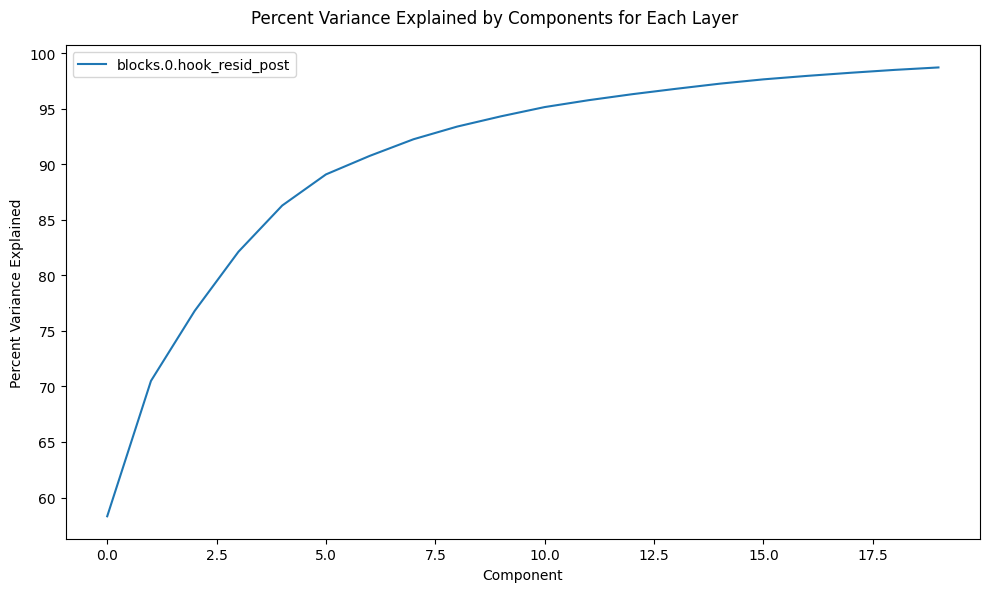

In [ ]:
def analyze_activations(acts, layer_name):
    acts = acts.cpu().numpy().reshape(-1, train_config['d_model'])
    U, S, Vt = np.linalg.svd(acts, full_matrices=False)
    percent_variance_explained = (S**2 / (S**2).sum()) * 100  # Corrected calculation
    return percent_variance_explained

# Create a single figure
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle('Percent Variance Explained by Components for Each Layer')

# Loop through each item in cache
for layer_name, acts in cache.items():
    percent_variance_explained = analyze_activations(acts, layer_name)
    
    # Plot the percent variance explained by each component
    ax.plot(percent_variance_explained.cumsum()[:20], label=layer_name)

ax.set_xlabel('Component')
ax.set_ylabel('Percent Variance Explained')
ax.legend()

plt.tight_layout()
plt.show()

[ 47.80685204  71.63569149  94.7064525  100.        ]


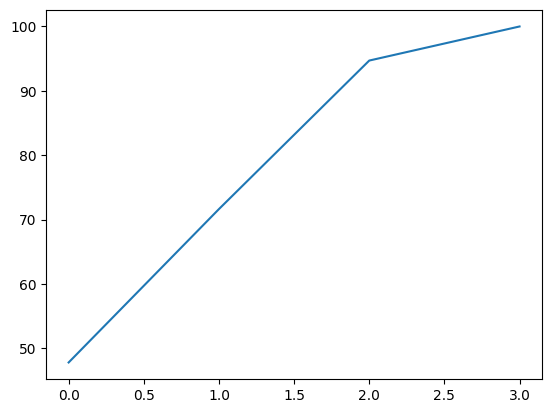

In [ ]:
# do svd on the actual belief states
unique_states = np.unique(final_tree_beliefs, axis=0)
belief_states = np.array(unique_states)
U, S, Vt = np.linalg.svd(belief_states, full_matrices=False)
percent_variance_explained = S**2 / (S**2).sum() *100
percent_variance_explained = np.cumsum(percent_variance_explained)
print(percent_variance_explained)

# plot the percent variance explained by each component
plt.plot(percent_variance_explained)
plt.show()

## Evaluate accuracy of the model

In [ ]:
# Calculate accuracy
valid_dataset = CustomProcessDataset(final_process, sequence_length=train_config['n_ctx'], num_samples=10000, fixed=True)
accuracy, position_accuracy = compute_accuracy(model, valid_dataset, device)
print(f"Overall Accuracy: {accuracy:.4f}")

verbose = False
if verbose:
    # Plot the position-wise accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, train_config['n_ctx'] + 1), position_accuracy)
    plt.title("Accuracy by Position in Sequence")
    plt.xlabel("Position")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.show()